### TASK 1
Classifier for **notMNIST**: This dataset contains images of **alphabets A to J** in various fonts. Your task is to build a classifier for this dataset using CNN.
>- Classify each image into one of 10 classes
>- Show the effect of permuting the image pixels on CNN classifiers,



### About the Dataset

The notMNIST dataset is a collection of images containing the letters **A to J** in various fonts and styles. Each image is **28x28 pixels** and grayscale, which means the pixel intensity ranges from 0 (black) to 255 (white).  

The dataset is designed to be a bit like the MNIST digit dataset, but instead of digits, we have **alphabet letters**.

A few things to note about this dataset:  
- **10 classes** corresponding to letters A-J.  
- Images vary in font, size, and style.

The notMNIST dataset comes **pre-split** into a **training set** and a **test set**:  

- **Training set:** ~15K rows  
- **Test set:** ~ 3.75 K rows



In [ ]:
# Load the dataset
from datasets import load_dataset

ds = load_dataset("anubhavmaity/notMNIST")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-66ec62000fa1b4(…):   0%|          | 0.00/7.10M [00:00<?, ?B/s]

data/test-00000-of-00001-1136ef192260594(…):   0%|          | 0.00/1.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14979 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3745 [00:00<?, ? examples/s]

### Setup

Before we start building our CNN, we first import the necessary libraries.

We also set **random seeds** for PyTorch, NumPy, and Python's built-in random module. This ensures that our experiments are **reproducible** — if we run the notebook again, we get the same results.  

Finally, we define the **device** (GPU if available, otherwise CPU) so that our model can train efficiently.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy, random


# set the PseudoRandom Generator Seeds for reproducibility
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)


# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Raw Dataset Example

A sample from the HuggingFace notMNIST training set looks like this:

- `image`: a PIL grayscale image of size 28x28 (`mode=L`)  
- `label`: an integer from 0 to 9 (here 6)

In [ ]:
print(ds['train'][0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7C29DD63A960>, 'label': 6}


### Loading and Preprocessing the Dataset

The notMNIST dataset already comes split into **training** and **test** sets.

Since our CNN works best with **tensor inputs**, we transform the images into PyTorch tensors and normalize them. Normalization scales the pixel values to roughly **[-1, 1]**, which helps the network train faster and more stably.  

We also define a **collate function** for our DataLoader, which organizes a batch of images and labels into tensors suitable for training — similar to how we handle the MNIST dataset.  

Finally, we create **DataLoaders** for both training and test sets. The training loader shuffles the data to prevent the model from learning the order of the images, while the test loader keeps the order fixed for consistent evaluation.


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply transform inside HF dataset
def transform_examples(batch):
    batch["image"] = [transform(img) for img in batch["image"]]
    return batch

ds.set_transform(transform_examples)

# Define collate function to make batches like MNIST
def collate_fn(batch):
    images = torch.stack([item["image"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return images, labels

# Create DataLoaders
train_loader = DataLoader(ds["train"], batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(ds["test"],  batch_size=1000, shuffle=False, collate_fn=collate_fn)


### Displaying Sample Training Images

We take a batch of images from the DataLoader and show the first 20.
Each image is grayscale, and its label is displayed on top.
This gives a quick visual check of the dataset.


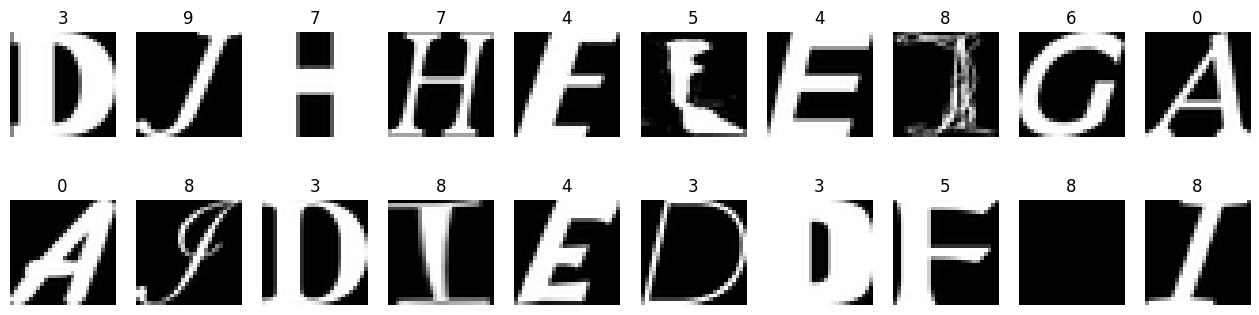

In [ ]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),cmap='gray')
    plt.axis('off')
    plt.title(label)

### Exploratory Data Analysis (EDA) after Preprocessing

1. **Class Distribution:**  
   The class more or less seem to be balanced, where each class have roughly same number of training samples.

2. **Image Shape and Type:**  
   Each image has been converted to a PyTorch tensor of shape `[1, 28, 28]` (channels x height x width), which is the format expected by the CNN.

3. **Pixel Value Range:**  
   After normalization, pixel values lie between -1 and 1. This ensures stable training and faster convergence.

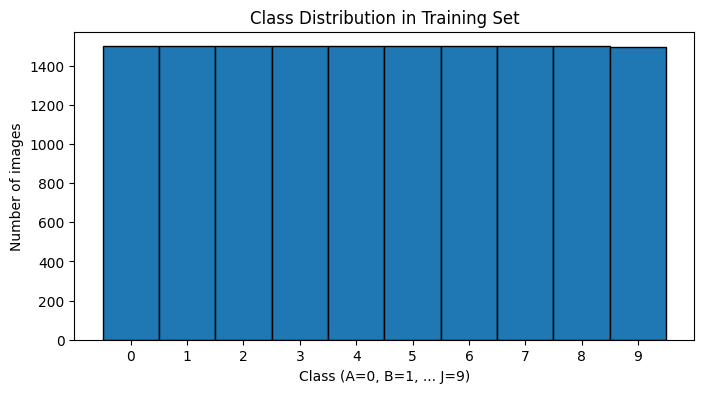

Example image shape: <built-in method size of Tensor object at 0x7c29d3e9a670>
Example image type: <class 'torch.Tensor'>
Batch pixel min: -1.0
Batch pixel max: 1.0
Batch pixel mean: -0.1290191113948822


In [ ]:
# Class distribution
labels = [item['label'] for item in ds['train']]
plt.figure(figsize=(8,4))
plt.hist(labels, bins=range(11), edgecolor='black', align='left')
plt.xticks(range(10))
plt.xlabel("Class (A=0, B=1, ... J=9)")
plt.ylabel("Number of images")
plt.title("Class Distribution in Training Set")
plt.show()

# Check image shape and type
print("Example image shape:", ds['train'][0]['image'].size)
print("Example image type:", type(ds['train'][0]['image']))

# Pixel value range in a batch
image_batch, label_batch = next(iter(train_loader))
print("Batch pixel min:", image_batch.min().item())
print("Batch pixel max:", image_batch.max().item())
print("Batch pixel mean:", image_batch.mean().item())


In [ ]:
print(f"Length of trainining samples:{ds['train'].shape}")
print(f"Length of trainining samples:{ds['test'].shape}")

Length of trainining samples:(14979, 2)
Length of trainining samples:(3745, 2)


---------------------------------------------

### Training and Evaluation Functions

- **get_n_params(model)**: Computes the total number of trainable parameters in the model.

- **train(epoch, model)**: Trains the given model for one epoch. Performs forward pass, computes loss, backpropagates gradients, updates weights, and records training accuracy for the epoch.

- **test(model)**: Evaluates the model on the test set. Computes total loss and accuracy, and stores test accuracy for tracking over epochs.



In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
train_accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    correct = 0
    total = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        # clear old gradients
        optimizer.zero_grad()
        output = model(data)
        # compute loss
        loss = F.cross_entropy(output, target)
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()
        # add loss
        train_loss += loss.item() * data.size(0)
        # compute batch accuracy
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total += target.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
      # average loss & accuracy over epoch
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    train_accuracy_list.append(train_accuracy)

    #print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #train_loss, correct, total, train_accuracy))


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)   # send to device
        output = model(data)
        # compute loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        # number of correct predictions
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### CNN Architecture for notMNIST

- **Conv1 (3x3 kernel, 32 channels):**  
  We start with a small kernel to pick up **basic features** like edges and corners. 32 channels let the network learn multiple patterns at this level.  

- **Conv2 (3x3 kernel, 64 channels):**  
  Going a bit deeper, this layer combines the low-level features to detect **more complex shapes**. BatchNorm keeps training stable and speeds things up.  

- **Conv3 (5x5 kernel, 128 channels):**  
  More channels can generate richer feature maps.

- **Fully Connected Layer ($128*4*4$ -> 128):**  
  After the pooling layers, the feature maps are flattened and condensed to 128 neurons to get a **compact representation** of the important features.  

- **Dropout (0.6):**  
  Randomly turns off neurons during training to **prevent overfitting**.  

- **Output Layer (128 -> 10):**  
  Finally, we map the features to the **10 classes (A-J)**.  

- **Why more channels?**  
  notMNIST has letters in **different fonts and styles**, so more channels help the CNN learn **richer and more varied patterns**.


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Training Setup for CNN on notMNIST

- **Input size:** 28x28 pixels  
- **Output size:** 10 classes (letters A–J).  
 - **Optimizer:** Stochastic Gradient Descent (SGD) with learning rate 0.01 and momentum 0.5 to speed up convergence.  
- **Training loop:** We train for 10 epochs, computing loss and updating weights with backpropagation each batch, and check performance on the test set after every epoch.  
- **Number of parameters:** Prints the total trainable parameters so we know the model size.


In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 487754
Train Epoch: 0 [0/14979 (0%)]	Loss: 2.408118
Train Epoch: 0 [6400/14979 (43%)]	Loss: 0.865074
Train Epoch: 0 [12800/14979 (85%)]	Loss: 0.533454

Test set: Average loss: 0.3421, Accuracy: 3376/3745 (90%)

Train Epoch: 1 [0/14979 (0%)]	Loss: 0.580716
Train Epoch: 1 [6400/14979 (43%)]	Loss: 0.388804
Train Epoch: 1 [12800/14979 (85%)]	Loss: 0.228109

Test set: Average loss: 0.7976, Accuracy: 3002/3745 (80%)

Train Epoch: 2 [0/14979 (0%)]	Loss: 0.506930
Train Epoch: 2 [6400/14979 (43%)]	Loss: 0.264354
Train Epoch: 2 [12800/14979 (85%)]	Loss: 0.386379

Test set: Average loss: 0.2424, Accuracy: 3467/3745 (93%)

Train Epoch: 3 [0/14979 (0%)]	Loss: 0.216625
Train Epoch: 3 [6400/14979 (43%)]	Loss: 0.302716
Train Epoch: 3 [12800/14979 (85%)]	Loss: 0.249054

Test set: Average loss: 0.2169, Accuracy: 3488/3745 (93%)

Train Epoch: 4 [0/14979 (0%)]	Loss: 0.283459
Train Epoch: 4 [6400/14979 (43%)]	Loss: 0.082477
Train Epoch: 4 [12800/14979 (85%)]	Loss: 

### Observations

We see from the plot that train and test accuracy generally increase over the epochs, with occasional dips. These dips occur due to stochastic gradient updates and regularization effects (like dropout), which can temporarily reduce accuracy. Despite these fluctuations, the overall trend shows that the model is learning and improving its performance on both training and test sets.

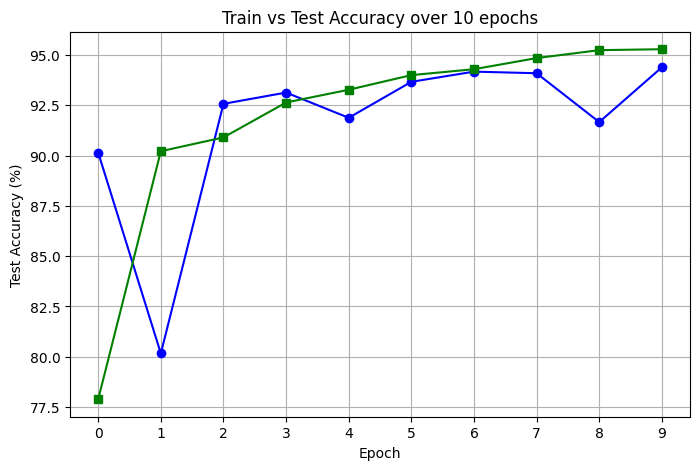

In [ ]:
epochs = range(10)  # 10 epochs
plt.figure(figsize=(8,5))
plt.plot(epochs, accuracy_list[-10:], marker='o', color='blue')
plt.plot(epochs, train_accuracy_list[-10:], marker='s', color='green', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Train vs Test Accuracy over 10 epochs')
plt.xticks(epochs)
plt.grid(True)
plt.show()


In [ ]:
# Function for viewing an image and it's predicted classes.
def visualize_pred(img, pred_prob, real_label):
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])

    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(numpy.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

### Prediction Visualization

We can see from the plots that the CNN is assigning **high probabilities to the correct classes** for most images.  
This indicates that the network has learned meaningful features and is confident in its predictions.


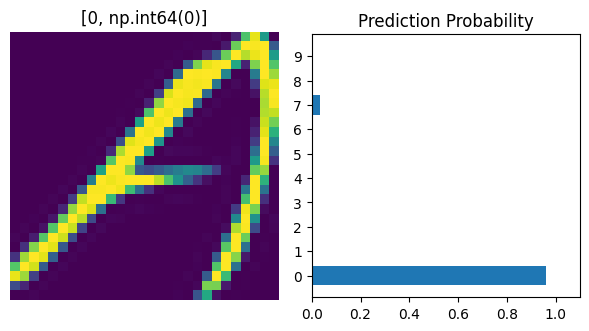

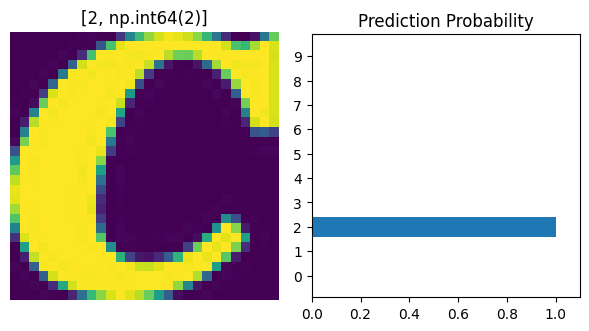

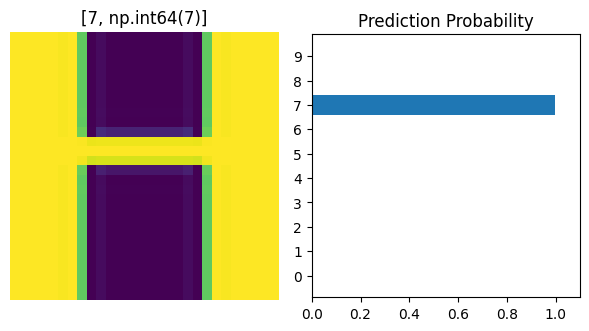

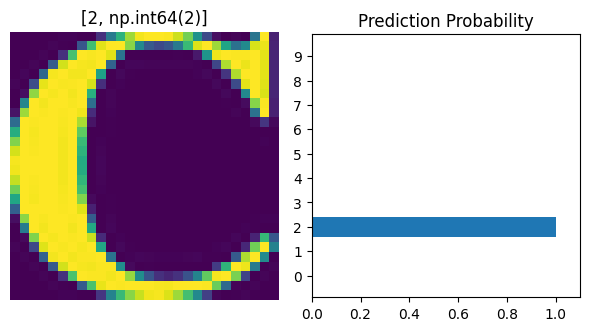

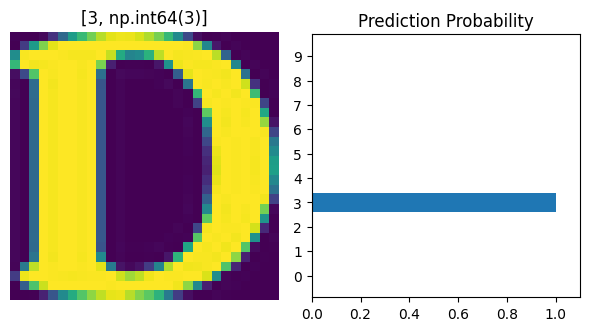

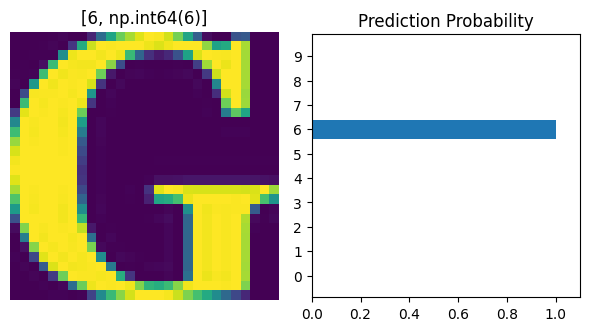

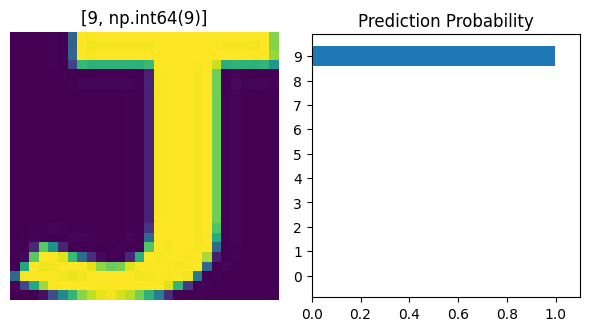

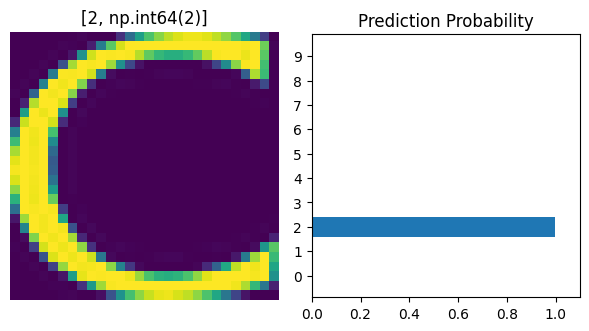

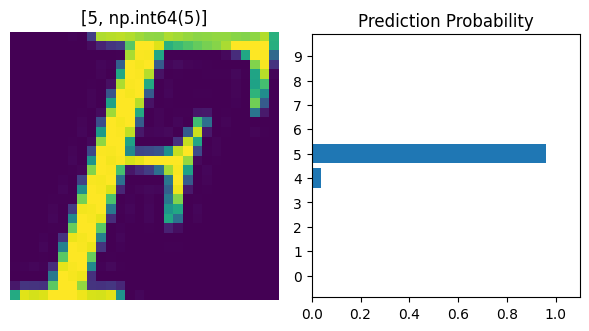

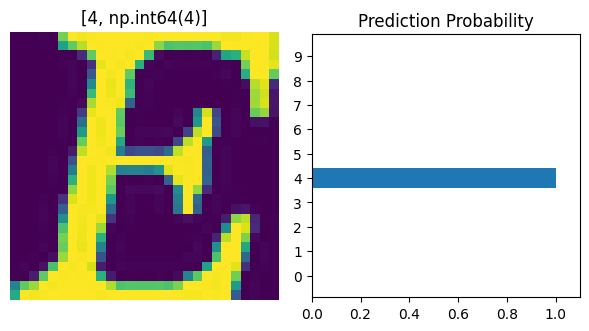

In [ ]:
model_cnn.to('cpu')

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

----

### Effect of permuting the image pixels on CNN classifiers


- Each 28x28 image is flattened to a 784-length vector.  
- A **fixed random permutation** is applied to the pixels, scrambling them in the same way for all images.  
- The permuted vector is reshaped back to 28x28 for visualization.  
- Left column: original images; right column: permuted images.  
- This visually demonstrates how scrambling pixels destroys spatial structure.

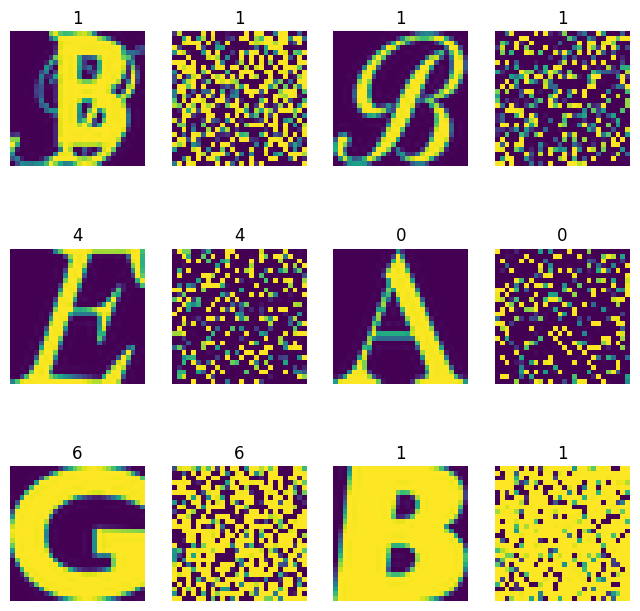

In [ ]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)

    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

- `scramble_train` performs one epoch of training on these permuted images using the labels.  
- `scramble_test` evaluates the CNN on permuted test images and computes accuracy.

In [ ]:
accuracy_list_s = []
train_accuracy_list_s = []
def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # compute batch accuracy
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total += target.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # compute epoch accuracy
    train_accuracy = 100. * correct / total
    train_accuracy_list_s.append(train_accuracy)

def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list_s.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### Training CNN on Permuted Images

- We train the same CNN architecture, but **all image pixels are permuted** in a fixed random order (`fixed_perm`).  
- This simulates a scenario where **spatial structure is destroyed**, testing how the CNN performs when it can’t rely on normal 2D patterns.  
- Training uses **SGD with learning rate 0.01 and momentum 0.5**, for 10 epochs.  
- After each epoch, we evaluate the model on the **similarly permuted test set**.


In [ ]:
print("Training on ", device)
model_cnn_3 = CNN(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 10):
    scramble_train(epoch, model_cnn_3, fixed_perm)
    scramble_test(model_cnn_3, fixed_perm)

Training on  cuda:0
Number of parameters: 487754
Train Epoch: 0 [0/14979 (0%)]	Loss: 2.321630
Train Epoch: 0 [6400/14979 (43%)]	Loss: 0.980561
Train Epoch: 0 [12800/14979 (85%)]	Loss: 0.683209

Test set: Average loss: 0.4956, Accuracy: 3174/3745 (85%)

Train Epoch: 1 [0/14979 (0%)]	Loss: 0.393003
Train Epoch: 1 [6400/14979 (43%)]	Loss: 0.604695
Train Epoch: 1 [12800/14979 (85%)]	Loss: 0.490003

Test set: Average loss: 0.4069, Accuracy: 3296/3745 (88%)

Train Epoch: 2 [0/14979 (0%)]	Loss: 0.180323
Train Epoch: 2 [6400/14979 (43%)]	Loss: 0.272279
Train Epoch: 2 [12800/14979 (85%)]	Loss: 0.312934

Test set: Average loss: 0.3645, Accuracy: 3354/3745 (90%)

Train Epoch: 3 [0/14979 (0%)]	Loss: 0.209011
Train Epoch: 3 [6400/14979 (43%)]	Loss: 0.217195
Train Epoch: 3 [12800/14979 (85%)]	Loss: 0.483239

Test set: Average loss: 0.3079, Accuracy: 3368/3745 (90%)

Train Epoch: 4 [0/14979 (0%)]	Loss: 0.270543
Train Epoch: 4 [6400/14979 (43%)]	Loss: 0.117139
Train Epoch: 4 [12800/14979 (85%)]	Loss: 

### Effect of Pixel Permutation on Accuracy

After training the CNN on **permuted images**, we observe that the test accuracy dropped slightly from ~94% (on normal images) to **92%**.  

Even though the spatial structure of the images is destroyed, the network still achieves high accuracy.
This is because pixels in every image are permuted the same way.
This shows that the CNN is able to **adapt and learn useful patterns** even from scrambled pixel arrangements, though it slightly loses some precision compared to the original images.



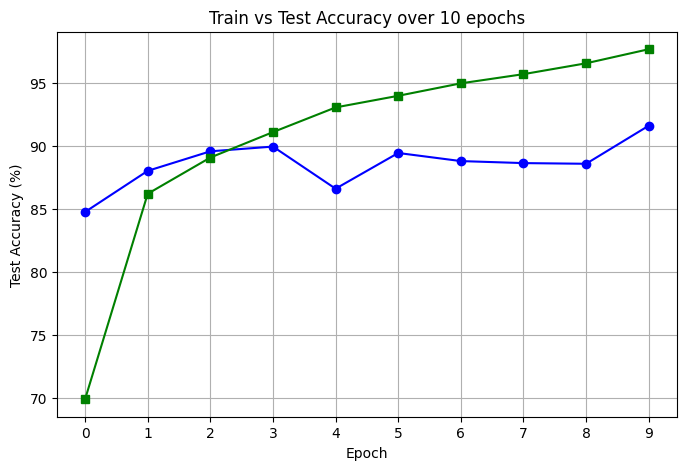

In [ ]:
epochs = range(10)  # 10 epochs
plt.figure(figsize=(8,5))
plt.plot(epochs, accuracy_list_s[-10:], marker='o', color='blue')
plt.plot(epochs, train_accuracy_list_s[-10:], marker='s', color='green', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Train vs Test Accuracy over 10 epochs')
plt.xticks(epochs)
plt.grid(True)
plt.show()


### Prediction Visualization

We can see from the plots that the CNN is assigning **high probabilities to the correct classes** for most images. Though some minor confusions are observed for some other classes.


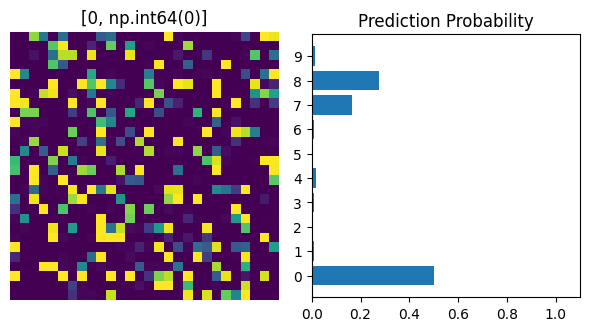

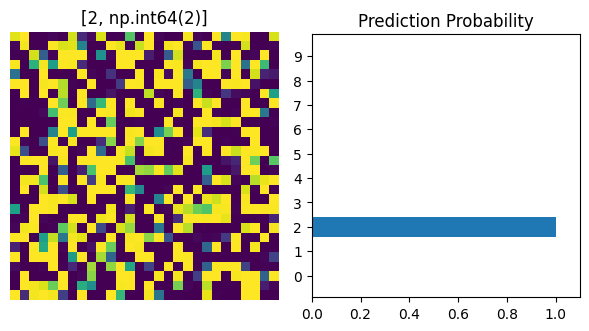

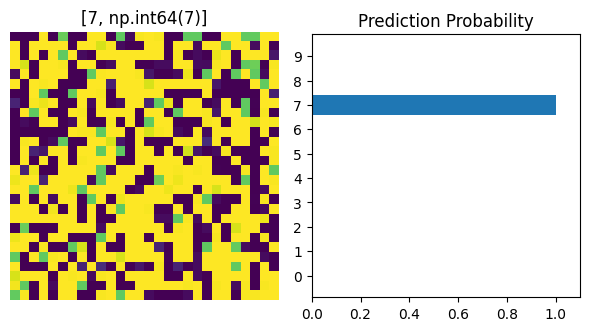

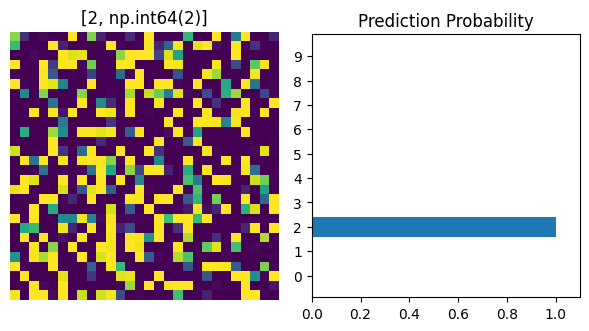

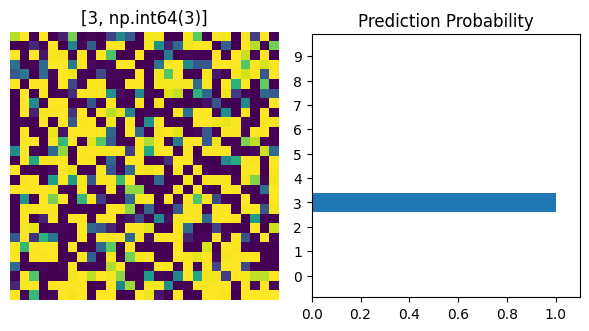

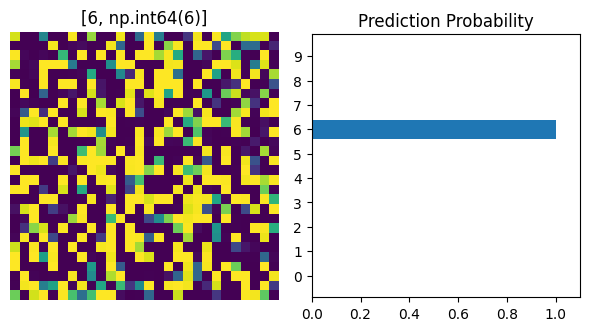

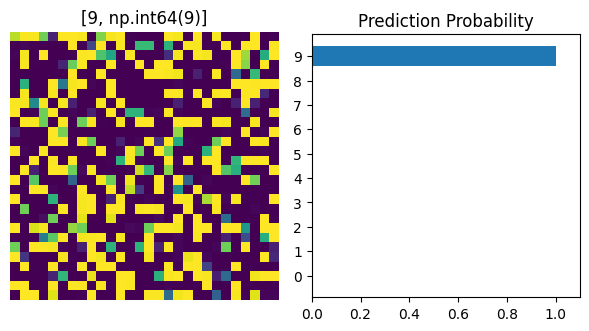

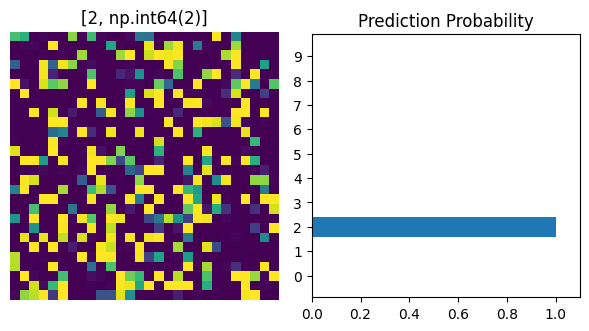

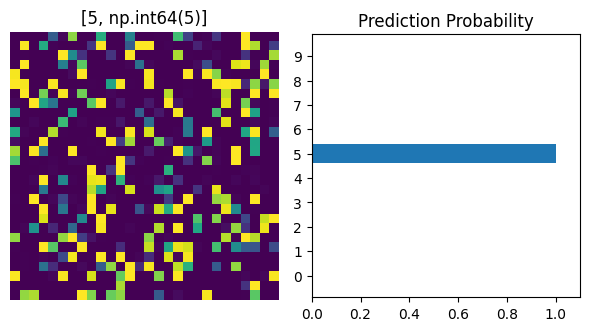

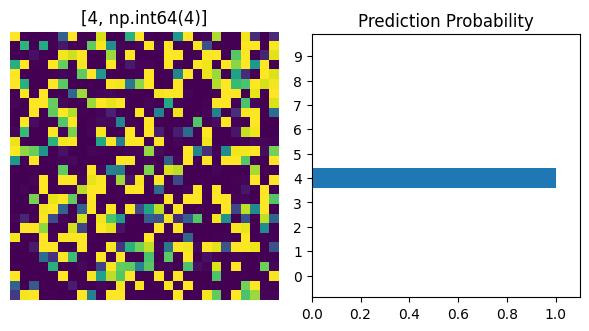

In [ ]:
model_cnn_3.to('cpu')

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_3(image_batch_scramble)
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)